In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import flopy
import flopy.plot.styles as styles
from dis2disu import Dis2Disu

In [2]:
ws = './disu_model'

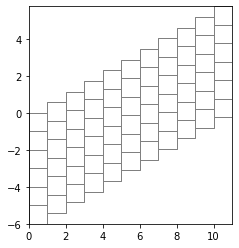

In [3]:
# Lx is the full width of the model domain. The grid spacing in
# the x direction is delr = Lx / ncol, and so the horizontal distance
# between the left and right boundary conditions is Lx - delr. The
# cells are square, i.e., delz = delr. The cross-sectional model has
# unit thickness "into the page," i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay * delz.
# Theta is the angle (deg) at which the channel slopes, and so the
# width of the "true" channel measured perpendicularly to the slope,
# i.e., the width avaiable for flow along the slope of the channel,
# is nlay * delz * cos(theta). The increase in elevation as one moves
# a column to the right is delr * tan(theta).

# adjustable grid parameters
nlay, ncol = 6, 11
Lx = 11.0
theta = 30.
#theta = math.atan(0.5) * 180. / math.pi   # this theta gives exactly 1/2 cell overlap

# grid parameters intended to remain fixed
nrow = 1
delc = 1.

# computed grid parameters
delr = float(Lx / ncol)
delz = delr
zoffset = delr * math.tan(theta * math.pi / 180.)
top = np.linspace(0., (ncol - 1) * zoffset, ncol)
top = top.reshape((nrow, ncol))
botm = np.empty((nlay, nrow, ncol))
botm[0] = top - delz
for k in range(1, nlay):
    botm[k] = botm[k - 1] - delz

# plot dis grid
delr = delr * np.ones(ncol, dtype=float)
delc = delc * np.ones(nrow, dtype=float)
mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                          top=top, botm=botm)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
xs = flopy.plot.PlotCrossSection(modelgrid=mgs, ax=ax, line={"row":0})
xs.plot_grid()

In [4]:
# scenario parameters
parameters = {
    "mymodel-s-nocc": {
        "xt3d": False,
        "staggered": False,
    },
    "mymodel-x-nocc": {
        "xt3d": True,
        "staggered": False,
    },
    "mymodel-s-cc": {
        "xt3d": False,
        "staggered": True,
    },
    "mymodel-x-cc": {
        "xt3d": True,
        "staggered": True,
    },
}

In [5]:
def print_spdis_summary(qx, qy, qz):
    from tabulate import tabulate

    jcolmid = int(ncol / 2)
    klaymid = int(nlay / 2)
    
    qmagmin = qangmin = qmagmid = float('inf')
    qmagmax = qangmax = qangmid = float('-inf')
    qmagavg = qangavg = 0.
    ncount = 0
    icell = -1
    for klay in range(nlay):
        for jcol in range(ncol):
            icell += 1
            qqx = qx[icell]
            qqz = qz[icell]
            qmag = math.sqrt(qqx * qqx + qqz * qqz)
            if (qqx == 0.):
                if (qqz == 0.):
                    qang = 0.
                elif (qqz > 0.):
                    qang = 90.
                else:
                    qang = -90.
            else:
                qang = math.atan(qqz / qqx) * 180. / math.pi
            ncount += 1
            qmagmin = min([qmagmin, qmag])
            qmagmax = max([qmagmax, qmag])
            qmagavg += qmag
            qangmin = min([qangmin, qang])
            qangmax = max([qangmax, qang])
            qangavg += qang
            if (klay == klaymid) and (jcol == jcolmid):
                qmagmid = qmag
                qangmid = qang
    qmagavg = qmagavg / ncount
    qangavg = qangavg / ncount
    qmagana = 1.
    slope = (top[0][1] - top[0][0]) / delr[0]
    qangana = math.atan(slope) * 180. / math.pi

    print ("\nSPECIFIC DISCHARGE:")
    qdata = [
        ["analytical", qmagana, qangana],
        ["mid-channel", qmagmid, qangmid],
        ["avg", qmagavg, qangavg],
        ["min", qmagmin, qangmin],
        ["max", qmagmax, qangmax],
    ]
    qhead = ["", "magnitude", "angle",]
    print(tabulate(qdata, headers=qhead, tablefmt="simple", floatfmt=".14f"))
    
    return

In [6]:
def build_model(sim_name, xt3d, staggered):
    global d2d
    
    # convert to disu grid
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered)
    
    sim_ws = os.path.join(ws, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name='./bin/mf6')
    tdis = flopy.mf6.ModflowTdis(sim)
    ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab')
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name,
                               save_flows=True, print_flows=True)
    disu = flopy.mf6.ModflowGwfdisu(gwf, **d2d.get_gridprops_disu6())
    ic = flopy.mf6.ModflowGwfic(gwf)
    npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                                  xt3doptions=xt3d,
                                  angle1=0., angle2=0., angle3=0.)

    # Set boundary heads to analytical values a la Bardot et al (2022),
    # assuming a head gradient of magnitude -1.:
    # head = cos(theta) * x + sin(theta) * z
    thetarad = theta * math.pi / 180.
    sintheta = math.sin(thetarad)
    costheta = math.cos(thetarad)
    xcleft = 0.5 * delr[0]
    xcright = Lx - 0.5 * delr[0]
    spd = []
    for klay in range(nlay):
        icleft = klay*ncol
        icright = icleft + ncol - 1
        zdrop = float(klay + 0.5) * delz
        zcleft = top[0][0] - zdrop
        zcright = top[0][ncol - 1] - zdrop
        hcleft = - (costheta * xcleft + sintheta * zcleft)
        hcright = - (costheta * xcright + sintheta * zcright)
        spd.append([(icleft,), hcleft])
        spd.append([(icright,), hcright])

    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=spd)

    budget_file = sim_name + '.bud'
    head_file = sim_name + '.hds'
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord=budget_file,
                                head_filerecord=head_file,
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                                printrecord=[('BUDGET', 'ALL'), ('HEAD', 'ALL')],)

    return sim

In [7]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_model(key, **params)
    sim.write_simulation(silent=silent)
    success, buff = sim.run_simulation(silent=silent, report=True)
    if not success:
        print(buff)
    else:
        plot_results(idx, sim)

In [8]:
def plot_results(idx, sim):

    sim_name = list(parameters.keys())[idx]
    sim_ws = os.path.join(ws, sim_name)
    gwf = sim.get_model(sim_name)
    staggered = parameters[sim_name]["staggered"]

    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    # if cross-connections, recalculate qx taking into account overlap areas
    if staggered:
        flowja = bud.get_data(text='FLOW-JA')[0][0][0]
        gp = d2d.get_gridprops_disu6()
        iac = gp["iac"]
        ja = gp["ja"]
        ihc = gp["ihc"]
        topbycell = gp["top"]
        botbycell = gp["bot"]
        hwva = gp["hwva"]
        iconn = -1
        icell = -1
        for il in iac:
            icell += 1
            qxnumer = 0.
            qxdenom = 0.
            for ilnbr in range(il):
                iconn += 1
                if ihc[iconn] == 2:
                    inbr = ja[iconn]
                    if (inbr == icell):
                        continue
                    dz = min(topbycell[icell], topbycell[inbr]) - max(botbycell[icell], botbycell[inbr])
                    qxincr = flowja[iconn] / (hwva[iconn] * dz)
                    # equal weight given to each face, but could weight by distance instead
                    if (inbr < icell):
                        qxnumer += qxincr
                    else:
                        qxnumer -= qxincr
                    qxdenom += 1.
            qx[icell] = qxnumer / qxdenom

    # print specific discharge summary
    print_spdis_summary(qx, qy, qz)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_array(head)
    xs.plot_grid()
    xs.plot_vector(qx, qy, qz, normalize=False, color="white")

    # save figure
    figure_ext = ".png"
    fpth = os.path.join(
        "..", "figures", "{}-head{}".format(sim_name, figure_ext)
    )
    
    fig.savefig(fpth)
    
    return

Simulation results for scenario 0, which features:
1. no cross-connections (not staggered)
2. standard conductance formulation (xt3d off)


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.15812169429512   4.40508647828339
avg          1.18552282900020  10.66704930740286
min          0.78615267109896   2.39328170488982
max          1.75124730664751  38.39088871981613


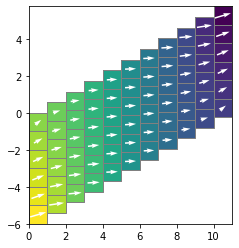

In [9]:
simulation(0)

Simulation results for scenario 1, which features:
1. no cross-connections (not staggered)
2. xt3d


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.03808857062696   4.84913524103195
avg          1.08261852514846  11.75542582350578
min          0.70389489468688   2.66906636907733
max          1.66491123474858  42.69124875128474


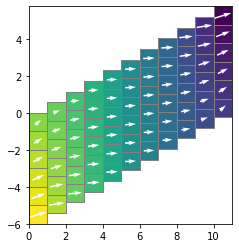

In [10]:
simulation(1)

Simulation results for scenario 2, which features:
1. cross-connections (staggered)
2. standard conductance formulation (xt3d off)


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.02264804588361  24.39868606682424
avg          1.06189337858883  24.91810798070954
min          0.97640357240278  21.56672056853805
max          1.36023166685126  30.80269970389571


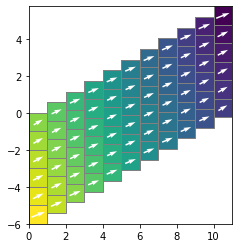

In [11]:
simulation (2)

Simulation results for scenario 3, which features:
1. cross-connections (staggered)
2. xt3d


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00000000018347  30.00000004680312
avg          1.00000000066281  30.00000000595226
min          0.99999999678140  29.99999961820053
max          1.00000000677581  30.00000010647039


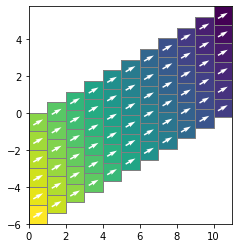

In [12]:
simulation(3)